# Backtesting a Trading Strategy Part 3

## How to Backtest A Trading Strategy Using Python

## Introduction
Backtesting is a tool to measure the performance of a trading strategy using historical data. The backtesting process consists of three parts: 1. determining the universe of securities where we will invest in (e.g. equity or fixed income? US or emerging markets?); 2. gathering historical data for the universe of securities; and 3. implementing a trading strategy using the historical data collected.  

In the previous articles, I illustrated the first two steps in the backtesting process of determining the universe of stocks, and collecting historical data for each constituent. In this article, I will illustrate the last step of the backtesting process by implementing a mean-reverting trading strategy.

## A Mean-Reverting Trading Strategy
We implement a mean-reverting trading strategy based on [Khandain and Lo](http://web.mit.edu/Alo/www/Papers/august07.pdf). The idea is to buy the previous day's "losers", and sell the previous day's "winners". Stocks which underperform the market average are classified as "losers". While stocks which outperform the market average are classified as "winners".

For each stock $i$, we calculate the weight $w_{i, t}$ at time $t$

$$ w_{i, t} = - \frac{1}{N} \left( r_{i, t-1} - r_{market, t-1} \right). $$

where $N$ is the total number of stocks in the investment universe. Market return at time $t$ is calculated as

$$ r_{market, t-1} = \frac{1}{N} \sum_{i=1}^{N} r_{i, t-1}. $$

## Backtesting A Mean-Reverting Trading Strategy
### Step By Step
1. Load S&P historical data
2. Implement a mean-reverting trading strategy
3. Calculate performance metrics of the mean-reverting trading strategy

Import packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from pandas import Series, DataFrame

In [4]:
import pickle

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

### Load S&P Historical Data

Set an id for each index

In [7]:
id = ['sp500', 'sp400', 'sp600']

Create a dictionary to map each id to a tickers file

In [8]:
input_file = {'sp500': 'sp500_data.pickle',
              'sp400': 'sp400_data.pickle',
              'sp600': 'sp600_data.pickle'}

Create a dictionary to map each id to a S&P historical data

In [9]:
sp500_data = pd.DataFrame()
sp400_data = pd.DataFrame()
sp600_data = pd.DataFrame()
sp_data = {'sp500': sp500_data,
           'sp400': sp400_data,
           'sp600': sp600_data}

Retrieve S&P historical data

In [10]:
for i in id:
    # Load data 
    with open(input_file[i], 'rb') as f:
        sp_data[i] = pickle.load(f)
    f.close()
    
    # Select close prices
    sp_data[i] = sp_data[i].close

### Implement A Mean-Reverting Trading Strategy

Create a dictionary to map each id to a S&P returns data

In [11]:
sp500_returns = DataFrame()
sp400_returns = DataFrame()
sp600_returns = DataFrame()
sp_returns = {'sp500': sp500_returns,
              'sp400': sp400_returns,
              'sp600': sp600_returns}

Create a dictionary to map each id to a S&P market returns data

In [12]:
sp500_market_returns = Series()
sp400_market_returns = Series()
sp600_market_returns = Series()
sp_market_returns = {'sp500': sp500_market_returns,
                     'sp400': sp400_market_returns,
                     'sp600': sp600_market_returns}

Create a dictionary to map each id to a trading strategy weighting

In [13]:
sp500_weights = DataFrame()
sp400_weights = DataFrame()
sp600_weights = DataFrame()
sp_weights = {'sp500': sp500_weights,
              'sp400': sp400_weights,
              'sp600': sp600_weights}

Create a dictionary to map each id to a trading strategy pnl per stock

In [14]:
sp500_pnl = DataFrame()
sp400_pnl = DataFrame()
sp600_pnl = DataFrame()
sp_pnl = {'sp500': sp500_pnl,
          'sp400': sp400_pnl,
          'sp600': sp600_pnl}

Create a dictionary to map each id to a trading strategy pnl

In [15]:
sp500_pnl_net = Series()
sp400_pnl_net = Series()
sp600_pnl_net = Series()
sp_pnl_net = {'sp500': sp500_pnl_net,
              'sp400': sp400_pnl_net,
              'sp600': sp600_pnl_net}

Implement the mean-reverting trading strategy on investment universes: S&P 500, S&P MidCap 400, and S&P SmallCap indices

In [16]:
for i in id:
    
    # Calculate the returns
    sp_returns[i] = sp_data[i].pct_change()
    
    # Calculate the equally weighted market returns
    sp_market_returns[i] = sp_returns[i].mean(axis='columns')
    
    # Calculate the weights of each stock
    sp_weights[i] = - (sp_returns[i].sub(sp_market_returns[i], axis='index')).div(sp_data[i].count(axis='columns'), axis='index')
    
    # Adjust the weights to 0 if price or return is NaN
    sp_weights[i][sp_data[i].isna() | sp_data[i].shift(periods=1).isna()] = 0
    
    # Calculate the daily pnl
    # Idea is to buy yesterday's losers, and sell yesterday's winners
    sp_pnl[i] = (sp_weights[i].shift(periods=1)).mul(sp_returns[i], axis='index')
    sp_pnl_net[i] = sp_pnl[i].sum(axis='columns')
    

Plot the cumulative pnl of the mean-reverting strategy by investment universe

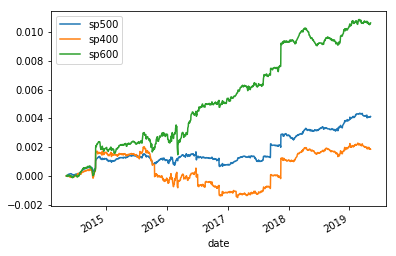

In [17]:
sp_pnl_net['sp500'].cumsum().plot()
sp_pnl_net['sp400'].cumsum().plot()
sp_pnl_net['sp600'].cumsum().plot()
plt.legend(id)

### Calculate Performance Metrics of the Mean-Reverting Trading Strategy

### Sharpe Ratio
1. What?
2. How?
3. ?

Divide the periods of observation

In [18]:
period = ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']

Create a dictionary to map each id to a trading performance

In [19]:
sp500_performance = pd.DataFrame()
sp400_performance = pd.DataFrame()
sp600_performance = pd.DataFrame()
sp_performance = {'sp500': sp500_performance,
                  'sp400': sp400_performance,
                  'sp600': sp600_performance}

Calculate the trading strategy's annualized Sharpe ratio, average daily returns and standard deviation

In [20]:
for i in id:
    
    # Initialize performance measures
    avg_returns = []
    std_returns = []
    sharpe = []
    
    # Calculate performance measures
    for j in range(len(period) - 1):
        # Period of observation
        start = period[j]
        end = period[j + 1]
        
        # Calculate average daily returns
        avg_returns.append(sp_pnl_net[i][start:end].mean())
        
        # Calculate standard deviation of daily returns
        std_returns.append(sp_pnl_net[i][start:end].std())
        
        # Calculate Sharpe ratio
        sharpe.append(np.sqrt(252) * avg_returns[j] / std_returns[j])
        
    # Update performance measures DataFrame
    sp_performance[i] = pd.DataFrame({'Avg Daily Returns': avg_returns,
                                      'Std Daily Returns': std_returns,
                                      'Sharpe Ratio': sharpe},
                                    index=['2014', '2015', '2016', '2017', '2018'])
    

Comparison of the trading strategy deployed on different investment universes

Sharpe ratio

In [21]:
sp_sharpe = pd.DataFrame({'S&P 500': sp_performance['sp500']['Sharpe Ratio'],
                          'S&P 400': sp_performance['sp400']['Sharpe Ratio'],
                          'S&P 600': sp_performance['sp600']['Sharpe Ratio']})

In [22]:
sp_sharpe

S&P 500   S&P 400   S&P 600
2014  2.363955  1.612314  1.492651
2015 -0.136814 -1.462997  0.896777
2016 -0.319982 -0.571094  1.291112
2017  1.535338  1.259514  2.358388
2018  1.813055  1.471451  1.326466

Average of daily returns

In [23]:
sp_avg_returns = pd.DataFrame({'S&P 500': (sp_performance['sp500']['Avg Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 400': (sp_performance['sp400']['Avg Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 600': (sp_performance['sp600']['Avg Daily Returns'] * 100).round(4).astype('str') + '%'})

In [24]:
sp_avg_returns

S&P 500   S&P 400  S&P 600
2014   0.0007%    0.001%  0.0012%
2015     -0.0%  -0.0007%  0.0004%
2016  -0.0001%  -0.0004%   0.001%
2017   0.0008%   0.0009%  0.0016%
2018   0.0004%   0.0004%  0.0004%

Standard deviation of daily returns

In [25]:
sp_std_returns = pd.DataFrame({'S&P 500': (sp_performance['sp500']['Std Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 400': (sp_performance['sp400']['Std Daily Returns'] * 100).round(4).astype('str') + '%',
                               'S&P 600': (sp_performance['sp600']['Std Daily Returns'] * 100).round(4).astype('str') + '%',})

In [26]:
sp_std_returns

S&P 500  S&P 400  S&P 600
2014  0.0049%  0.0095%  0.0123%
2015  0.0029%  0.0075%  0.0071%
2016  0.0068%  0.0111%   0.012%
2017  0.0084%  0.0112%  0.0106%
2018  0.0037%   0.004%  0.0049%

### Potential Improvements
To do
1. Transactions costs
2. Biasses
3. ?

## Conclusion
In this article, we implemented a mean-reverting trading strategy backtested it on our universe of stocks - the S&P 500, S&P MidCap 400 and S&P SmallCap 600 indices. The mean-reverting trading strategy performs best on the S&P 600 index which composed of small-capitalization stocks. In the next articles, we improve the backtesting process by including transaction costs and correcting for biasses. 